<a href="https://colab.research.google.com/github/VitaT/ML-python/blob/main/12_10_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
# !pip install kneed

import matplotlib.pyplot as plt   # visualization
import seaborn as sns             # visualization
import numpy as np                # data manipulation
import pandas as pd               # data manipulation, data processing, CSV file I/O (e.g. pd.read_csv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN
import scipy.cluster.hierarchy as shc

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
# from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, train_test_split


In [107]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



In [ ]:
# load data
url="https://raw.githubusercontent.com/VitaT/ML-python/main/data/fish.csv"
data = pd.read_csv(url)

In [6]:
# Checking data
data.info()
data.head(5)
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  147 non-null    object 
 1   Weight   147 non-null    float64
 2   Length1  147 non-null    float64
 3   Length2  147 non-null    float64
 4   Length3  147 non-null    float64
 5   Height   147 non-null    float64
 6   Width    147 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.2+ KB


,Species,Weight,Length1,Length2,Length3,Height,Width
13,Bream,600.0,29.4,32.0,37.2,14.9544,5.1708
106,Perch,700.0,34.5,37.0,39.4,10.8350,6.2646
85,Perch,130.0,20.5,22.5,24.0,5.8560,3.6240
71,Perch,100.0,16.2,18.0,19.2,5.2224,3.3216
33,Roach,87.0,18.2,19.8,22.2,5.6166,3.1746
127,Pike,500.0,42.0,45.0,48.0,6.9600,4.8960
21,Bream,700.0,31.9,35.0,40.5,16.2405,5.5890
144,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
82,Perch,130.0,20.0,22.0,23.5,6.1100,3.5250
131,Pike,1250.0,52.0,56.0,59.7,10.6863,6.9849


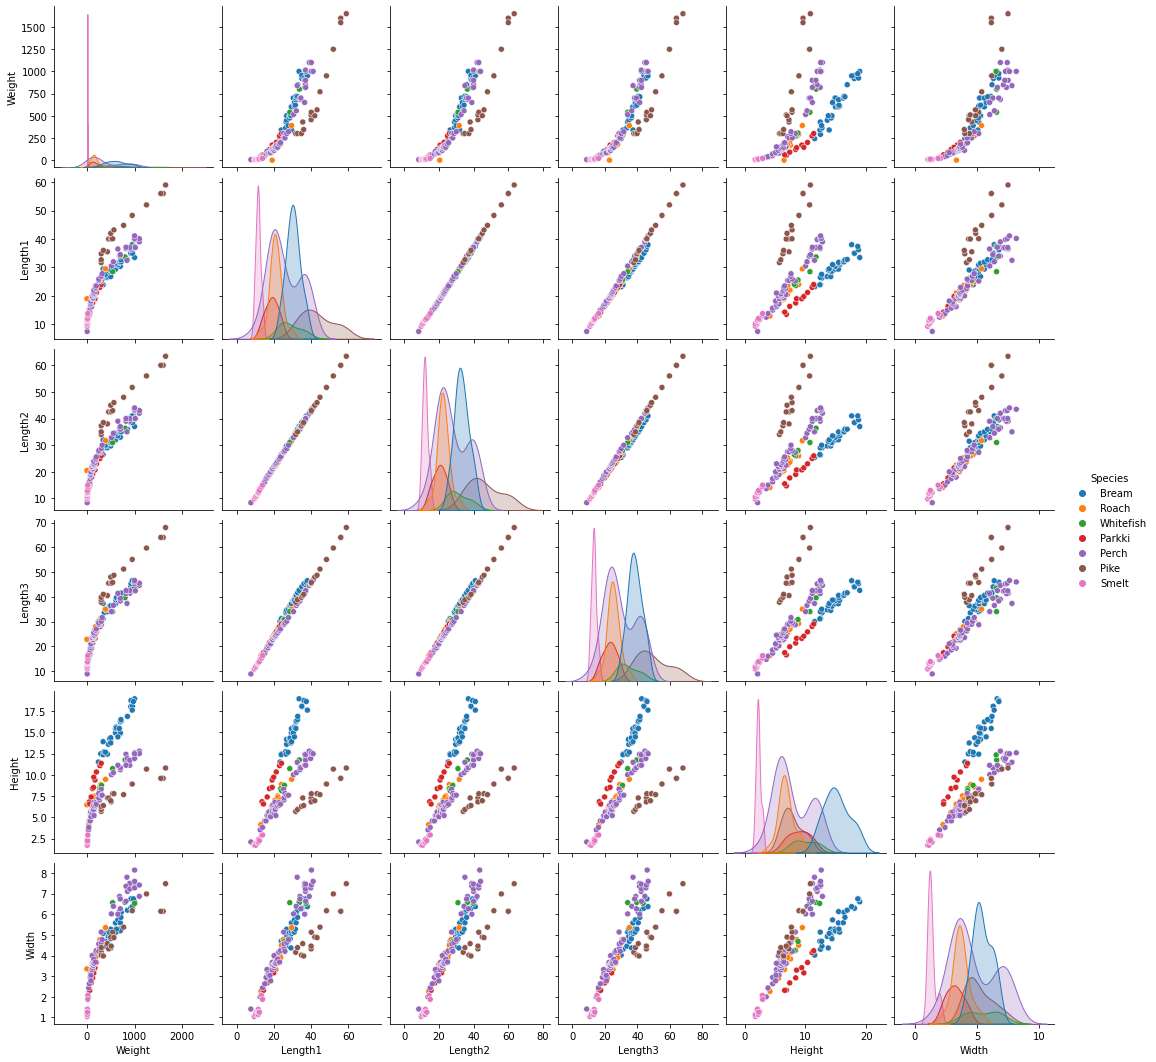

In [21]:
# exploratory plot
sns.pairplot(data, hue = "Species")

In [ ]:
# separate cluster names and predictors
y = data["Species"]
x = data.drop("Species", axis = 1)

# scale data
from sklearn.preprocessing import StandardScaler
scaled_x = StandardScaler().fit_transform(x)

In [62]:
# k-means
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=42)
y_pred = kmeans.fit_predict(x)

plt.scatter(x["Length3"], x["Height"], c=y_pred)

In [65]:
# The lowest SSE value
kmeans.inertia_
# Final locations of the centroid
kmeans.cluster_centers_
# The number of iterations required to converge
kmeans.n_iter_

3

Text(0.5, 0, 'number of principal components')

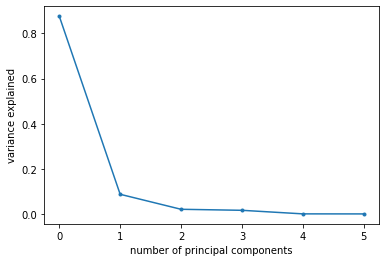

In [18]:
# create PCA estimator
pca = PCA()
# Conduct PCA
features_scaled_pca = pca.fit_transform(scaled_x)
# Show results
features_scaled_pca.shape

# variance explained
pca_var_ex = pd.Series(pca.explained_variance_ratio_)

plt.plot(pca_var_ex.index, pca_var_ex, marker = ".")
plt.ylabel("variance explained")
plt.xlabel("number of principal components")

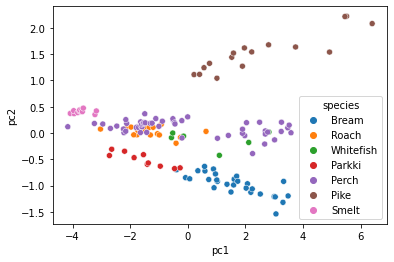

In [36]:
df = pd.DataFrame({
    'pc1':features_scaled_pca[:, 0],
    'pc2':features_scaled_pca[:, 1],
    'species':y})
sns.scatterplot(x="pc1", y="pc2", data=df, hue="species")

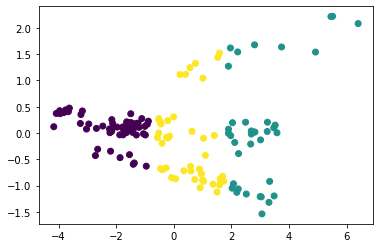

In [56]:
# k-means on pca
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(features_scaled_pca)

plt.scatter(df["pc1"], df["pc2"], c=y_pred)

[882.0000000000001, 320.54817111814975, 228.42351280184533, 167.1802049250075, 121.89147705531866, 88.1482589696679, 68.98706187908726, 55.31345882819745, 49.04031833710404, 42.5988105688789]


2

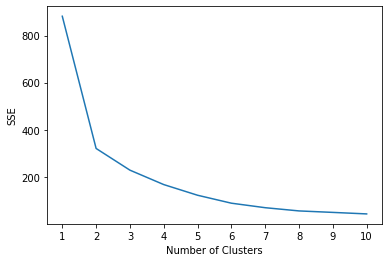

In [85]:
# selecting K
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled_pca)
    sse.append(kmeans.inertia_)

print(sse)
# graphics
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

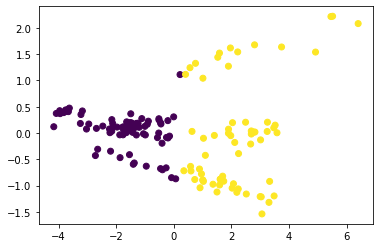

In [70]:
# k-means on pca with k=2
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(features_scaled_pca)

plt.scatter(df["pc1"], df["pc2"], c=y_pred)

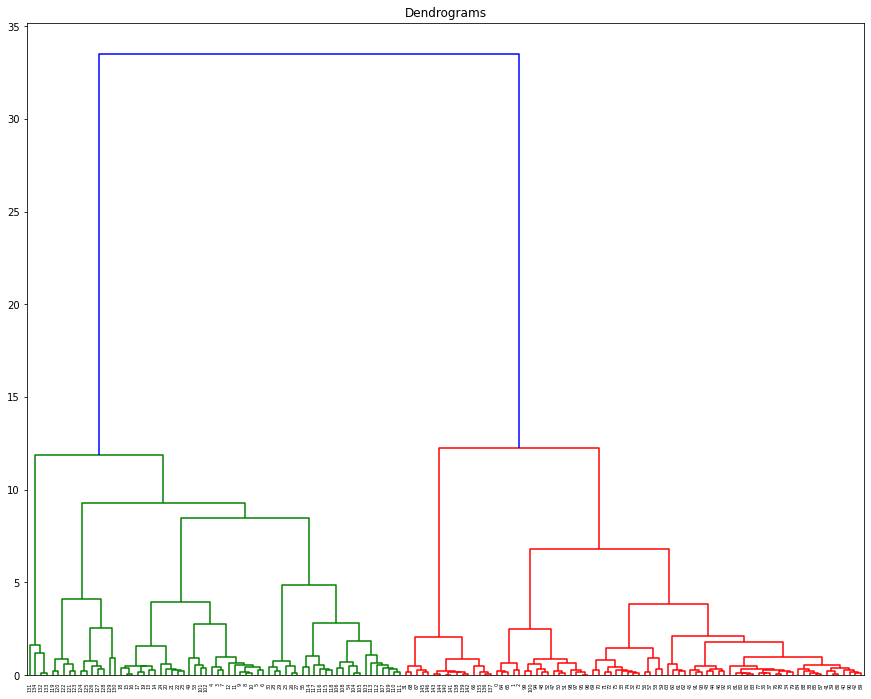

In [254]:
# Hierarchical clustering
# full dendrogram
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(15, 12))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(features_scaled_pca, method='average'))

# dendrogram trimming by height
plt.figure(figsize=(15, 12))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(features_scaled_pca, method='average'))
plt.axhline(y=2.2, color='r', linestyle='--')

# full dendrogram -- single
plt.figure(figsize=(15, 12))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(features_scaled_pca, method='single'))

# full dendrogram -- ward
plt.figure(figsize=(15, 12))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(features_scaled_pca, method='ward'))


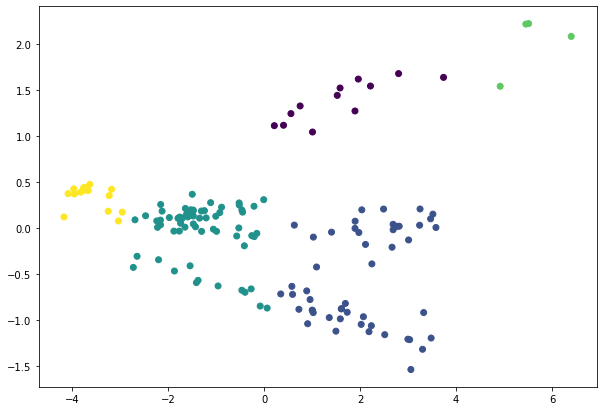

In [123]:
# create model
model_full = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="average")
# setting distance_threshold=0 ensures we compute the full tree.
# fit
model_full.fit(features_scaled_pca)

model_full.n_clusters_
model_full.labels_

# define the number of clusters wanted
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')  
cluster.fit_predict(features_scaled_pca)

# plot
plt.figure(figsize=(10, 7))  
plt.scatter(df['pc1'], df['pc2'], c=cluster.labels_) 

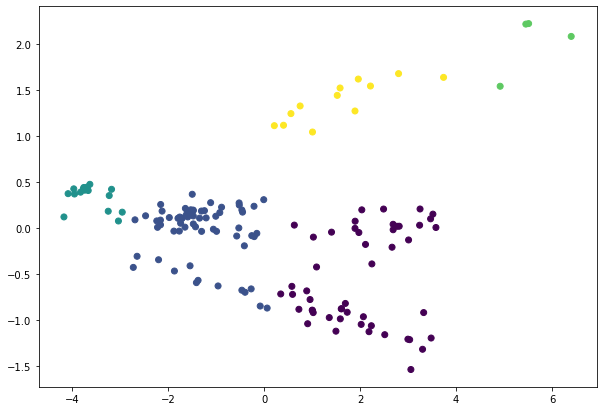

In [255]:
# define the number of clusters wanted
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(features_scaled_pca)

# plot
plt.figure(figsize=(10, 7))  
plt.scatter(df['pc1'], df['pc2'], c=cluster.labels_) 


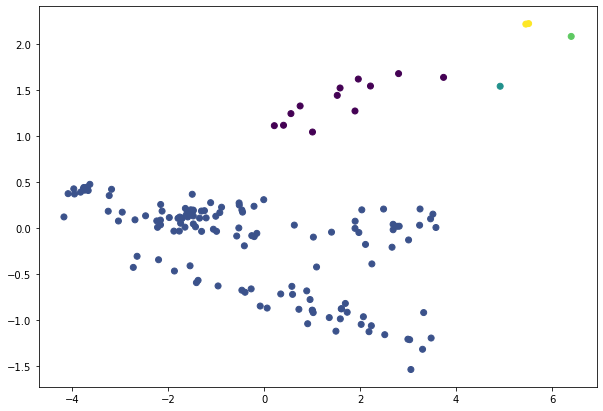

In [259]:
# define the number of clusters wanted
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
cluster.fit_predict(features_scaled_pca)

# plot
plt.figure(figsize=(10, 7))  
plt.scatter(df['pc1'], df['pc2'], c=cluster.labels_) 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


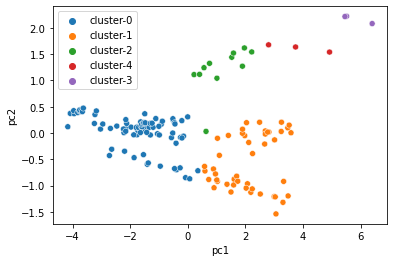

In [260]:
# mean shift
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(features_scaled_pca, quantile=0.2, n_samples=500)

# clustering
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(features_scaled_pca)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# number of clusters
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

# plot
sns.scatterplot(df['pc1'], df['pc2'], hue=["cluster-{}".format(x) for x in labels])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


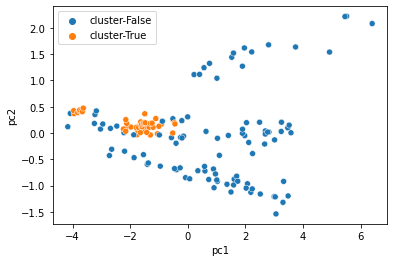

In [232]:
# initiate dbscan algorithm
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
dbscan.fit(features_scaled_pca)

# estimation of how good our clusters are
silhouette_score(features_scaled_pca, dbscan.labels_)

# claster labels
dbscan.labels_

# core clusters
dbscan.core_sample_indices_
core_points = np.zeros_like(dbscan.labels_, bool)
core_points[dbscan.core_sample_indices_] = True

# plot core and non-core points
sns.scatterplot(df['pc1'], df['pc2'], hue=["cluster-{}".format(x) for x in core_points])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


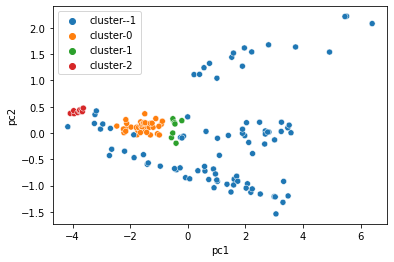

In [233]:
# plot clusters
sns.scatterplot(df['pc1'], df['pc2'], hue=["cluster-{}".format(x) for x in dbscan.labels_])

0.4186345559236996

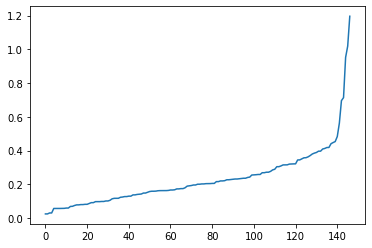

<Figure size 360x360 with 0 Axes>

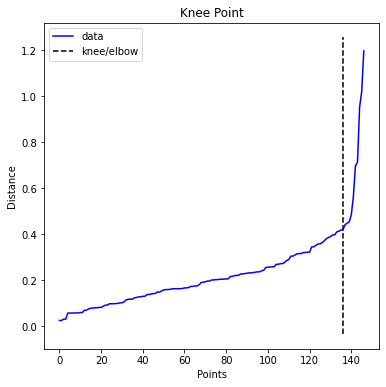

In [246]:

# We find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results
# Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as epsilon.

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_scaled_pca)
distances, indices = nbrs.kneighbors(features_scaled_pca)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

i = np.arange(len(distances))
kl = KneeLocator(i, distances, curve="convex", direction="increasing")
kl.elbow

# The optimal value for epsilon will be found at the point of maximum curvature.
fig = plt.figure(figsize=(5, 5))
kl.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


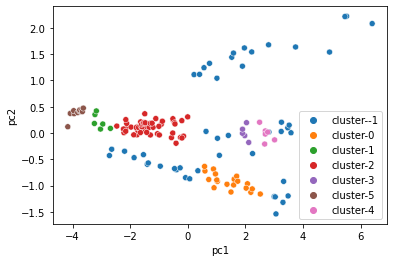

In [249]:
# initiate dbscan algorithm
dbscan = DBSCAN(eps=distances[kl.elbow])

# Fit the algorithms to the features
dbscan.fit(features_scaled_pca)

# claster labels
dbscan.labels_

# plot
sns.scatterplot(df['pc1'], df['pc2'], hue=["cluster-{}".format(x) for x in dbscan.labels_])


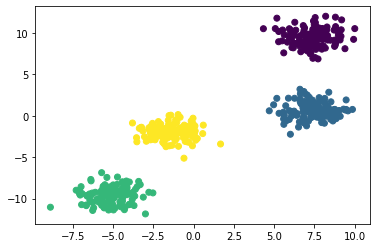

In [147]:
# commonly used way to learn and understand clustering -- generated synthetic data
features, labels = make_blobs(n_samples=500, n_features=2, centers=4, random_state=8)

# plot
plt.scatter(features[:, 0], features[:, 1], c = labels)

Can also look through and play around with: 

* https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
* https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py

# Task: 

find a good clustering pattern for this or suicide data
